# Error Plot for JCPexample 4

## Poiseuille Flow in Pipe

## Import stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions.DefineDomain
import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

## Error Plot

In [2]:
loadmodel = 'JCPexample4'

imagefilename = 'Error_Plot' + loadmodel
imagesfolder = "images/"

model = torch.load("savedmodels/" + loadmodel + ".pt").to('cpu')

### Setup Variables and Calculate Error

In [3]:

### Domain Parameters
dim_space = 3
dim_full = dim_space

L_top = 1
L_bot = 0
L_rad = 1

### Pressure Gradient and Viscosity
mu = 1
pressure_grad = 5
    
######################## Plotting and Error Parameters ############

numpts_z = 50
numpts_r = 5
numpts_th = 30
    
    
### Consider making each plot one at a time to reduce the matrix required in big memeory 
xg_r, xg_th, xg_z = torch.meshgrid( torch.linspace(0, L_rad, numpts_r),
                                    torch.linspace(0, 2*math.pi, numpts_th),
                                    torch.linspace(L_bot, L_top, numpts_z))

x1g = xg_r*torch.cos(xg_th)
x2g = xg_r*torch.sin(xg_th)

xg = torch.stack( [x1g.reshape(-1), x2g.reshape(-1), xg_z.reshape(-1) ], dim=1 ).requires_grad_(True)

ug = model(xg).reshape([numpts_r, numpts_th, numpts_z, 3]).detach().cpu().numpy()

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()
x3plot = xg_z.detach().cpu().numpy()

xrplot = xg_r.detach().cpu().numpy()

integral_factor = xrplot * 2*math.pi/(numpts_th-1) *L_rad/(numpts_r-1) * (L_top - L_bot)/(numpts_z -1)

u1_true = 0*x1plot
u2_true = 0*x1plot
u3_true = - pressure_grad/4/mu * (L_rad**2 - (x1plot**2 + x2plot**2))

u_true = np.stack([u1_true, u2_true, u3_true], axis=3)

L2_error = np.sqrt( np.sum( ((ug[:,:,:,0] - u1_true)**2 )* integral_factor ) \
                   + np.sum( ((ug[:,:,:,1] - u2_true)**2 )* integral_factor ) \
                    + np.sum( ((ug[:,:,:,2] - u3_true)**2 )* integral_factor ))

Linf_error = np.max(np.abs(ug - u_true))

L2_norm_true = np.sqrt( np.sum(  (u3_true**2)*integral_factor ) )
Linf_norm_true = np.max( np.abs( u3_true))

std_max = np.max( np.sqrt(np.mean( (ug[:,:,:,2] - u3_true)**2, axis=2)) )
std_min = np.min( np.sqrt(np.mean( (ug[:,:,:,2] - u3_true)**2, axis=2)) )

print("L2 Error = {:.4f}".format(L2_error))
print("Linf Error = {:.4f}".format(Linf_error))

print('Relative L2 Error = {:.4f}'.format(L2_error/L2_norm_true))
print('Relative Linf Error = {:.4f}'.format(Linf_error/Linf_norm_true))

#print(std_max)
#print(std_min)

L2 Error = 0.0561
Linf Error = 0.0732
Relative L2 Error = 0.0434
Relative Linf Error = 0.0586


C:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Plot

[Text(0, -1.0, ''),
 Text(0, -0.5, ''),
 Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, '')]

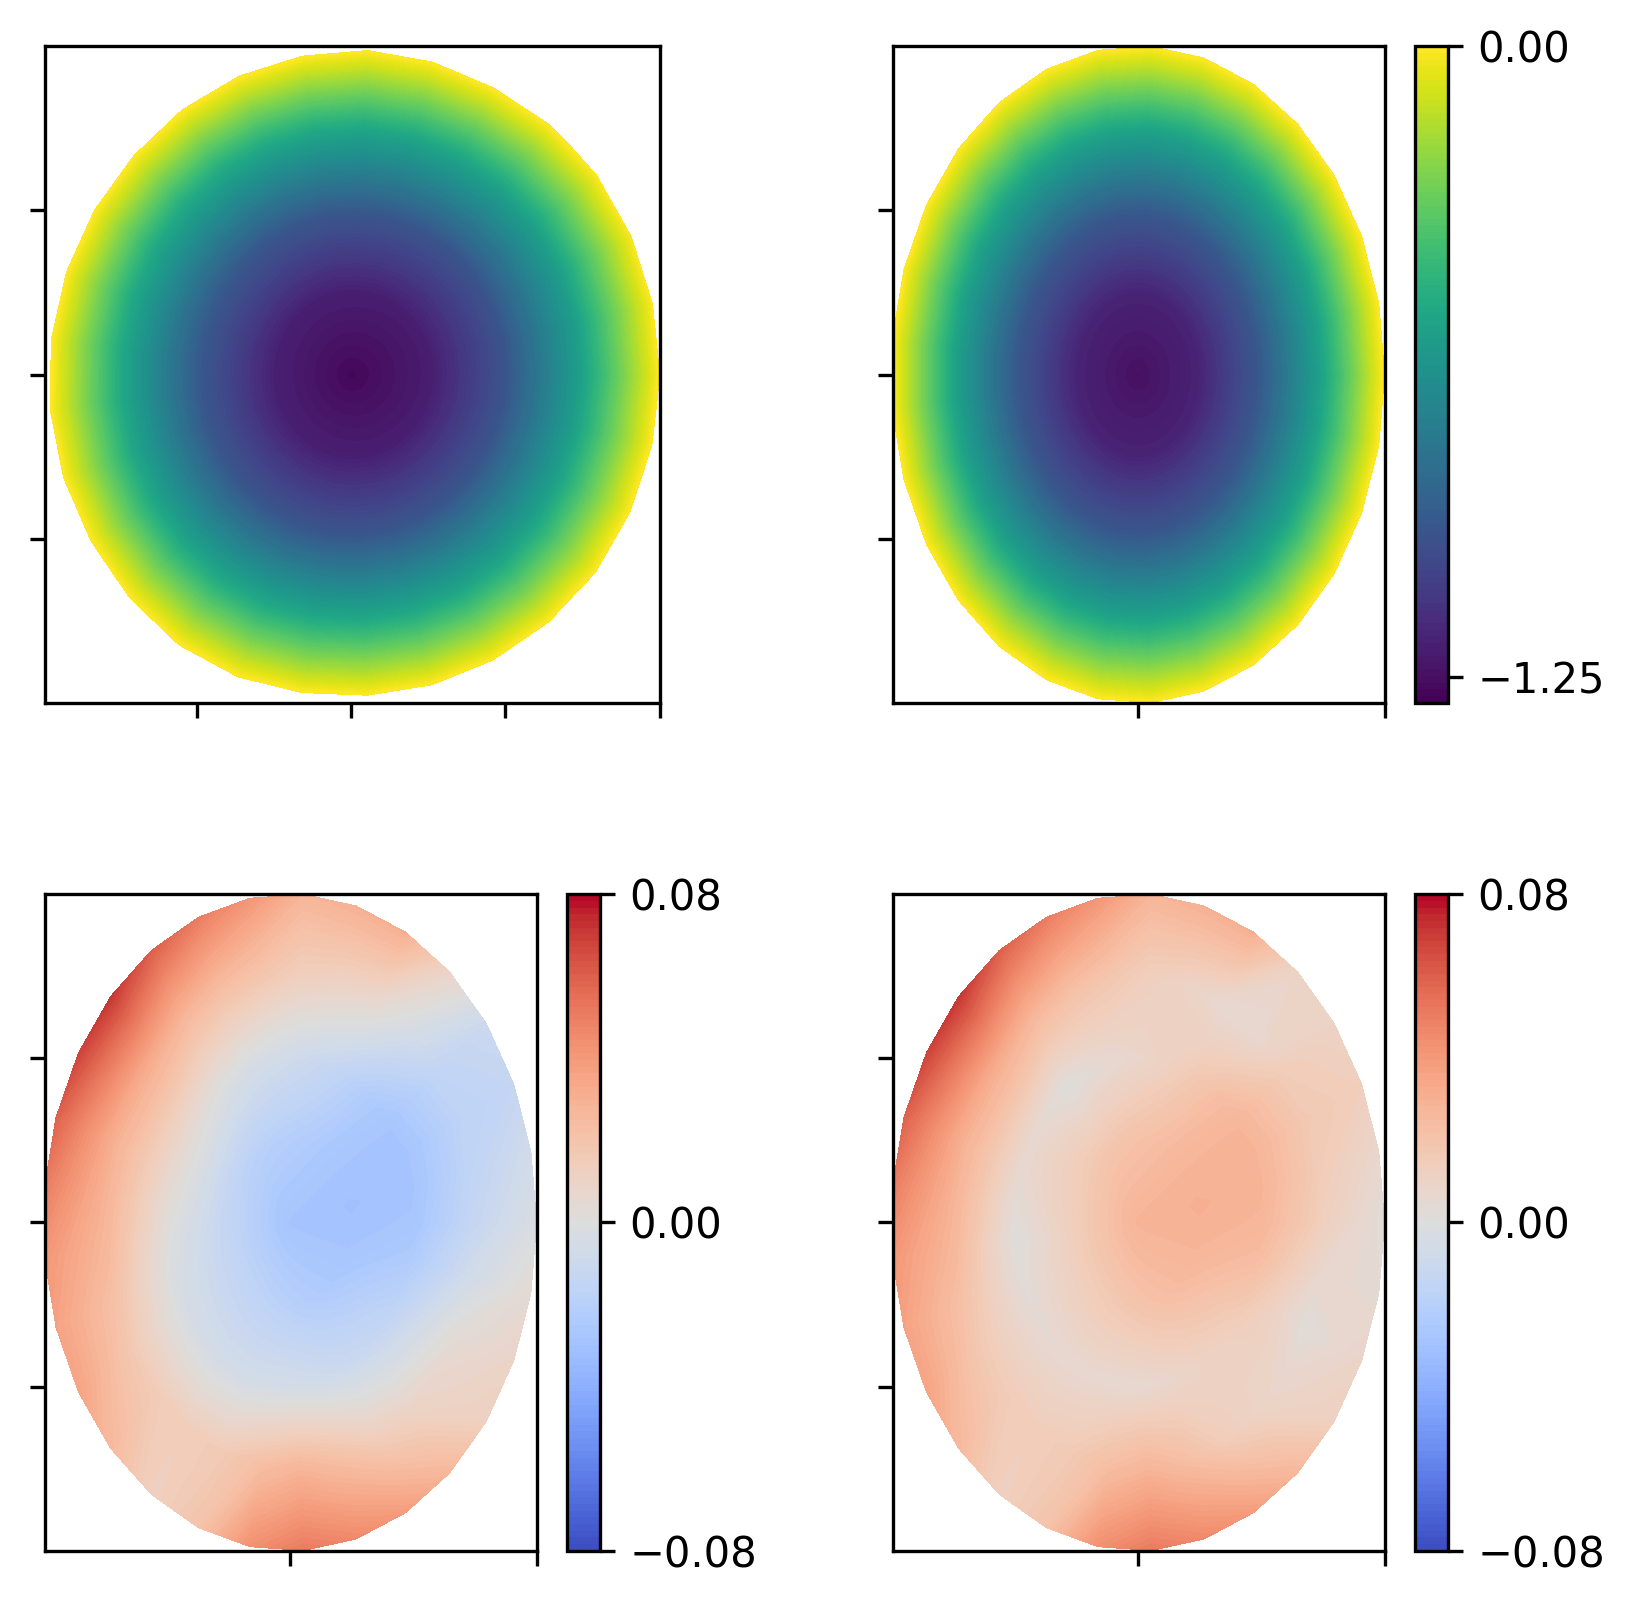

In [6]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(6,6))
plt.tight_layout(pad=2.5)

levels = np.linspace(-1.3,0,100)
levels_errors = np.linspace(-0.08, 0.08, 100)
level_tick = np.linspace(-1.25, 0, 2)
error_tick = np.linspace(-0.08, 0.08, 3)

#fig.suptitle('Learning Steady Poiseuille Flow in a Pipe' )

ax[0,0].contourf(x1plot[:,:,0], x2plot[:,:,0], np.mean( ug[:,:,:,2], axis=2), levels=levels, cmap = plt.cm.viridis)
#ax[0,0].set_title("u3 velocity, ") # + r'$L^2$ error = {:.2e}'.format(L2_error))
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])

contour0 = ax[0,1].contourf(x1plot[:,:,0], x2plot[:,:,0], u3_true[:,:,0], levels=levels, cmap = plt.cm.viridis)
#ax[0,1].set_title("True solution of u3 velocity, ") # + r'L inf error = {:.2e}'.format(Linf_error))
plt.colorbar(contour0, ticks=level_tick, ax=ax[0,1])
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])

contour2 = ax[1,0].contourf(x1plot[:,:,0], x2plot[:,:,0], np.mean( ug[:,:,:,2], axis=2) - u3_true[:,:,0], levels_errors, cmap=plt.cm.coolwarm)
#ax[1,0].set_title(r'Average of $u_3$ across z-axis')
plt.colorbar(contour2, ticks=error_tick, ax=ax[1,0])
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])

contour3 = ax[1,1].contourf(x1plot[:,:,0], x2plot[:,:,0], np.sqrt(np.mean( (ug[:,:,:,2] - u3_true)**2, axis=2)), levels_errors, cmap=plt.cm.coolwarm)
#ax[1,1].set_title(r'Standard Deviation of $u_3$ across z-axis')
plt.colorbar(contour3, ticks=error_tick, ax=ax[1,1])
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])